## Least Cost Pipeline Construction
This notebook imports the cost distance stack generated by `Create-Cost-Stack.ipynb` and a pipeline raster to compute a least cost "feeder" pipeline configuration. The workflow for this process is:
1. Import the stack of cost distance layers (one for each biogas source): $arr\_stack$.
1. Import the pipeline raster, setting non-pipeline cells to NaN: $arr\_pipeline$.
1. Determine which pixel among the pipeline pixels has the least cost among all farm cost distances rasters. This will serve as the location of the connection point to the existing pipeline: $C_0$.
1. Determine which farm is the source of this minimum point, done by finding which layer (in the stack of cost distance rasters) has the minimum value at that location. This represents the least cost biogas source: $F_0$.
1. Compute the least cost path connecting that farm ($F_0$) to the connection point ($C_0$): $LCP_0$.
1. Update the connection point layer ($C_0$) to include the least cost path ($LCP_0$): $Pipes_0$.
1. Remove the layer associated with $F_0$ from the stack of cost distance rasters ($arr\_CDsk$) and repeat steps 4-7:
    * Locate the minimim value among all remaining cost distance rasters to cells in the Pipes layer ($C_i$)...
    * Idenfity the source farm associated with this minimum ($F_i$)...
    * Compute the least cost path from from $F_i$ to $C_i$...
    * Update the connection point layer ($Pipes_{i+1}$)...

In [1]:
#Import packages
import numpy as np
import pandas as pd
from skimage import graph
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read the cost and cost distance stacks
arrCosts = np.load('../data/DuplinCostStack.npy')
arrStack = np.load('../data/DuplinStack.npy')

In [3]:
#Read in the pipeline rasters
ds =  gdal.Open('../data/processed/duplin_pipe_diameter.tif')
#Get the raster projection
ds_prj = ds.GetProjection()
#Get raster attributes
llx, x_size, x_angle, lly, y_angle, y_size = ds.GetGeoTransform()
#Extract Band1 as the cost array; divide by 100 to scale as a percentage
arrPipesAll = np.array(ds.GetRasterBand(1).ReadAsArray())
#Convert all pipe values to 1, others to NaN
arrPipesAll[arrPipesAll >= 0] = 1
arrPipesAll[arrPipesAll < 0] = -1
#Convert to a masked array (ignoring all values < 0, which are NoData)
arrPipes = np.ma.masked_array(arrPipesAll, mask=arrPipesAll < 0)

## Functions

In [4]:
def getMin(array_stack,array_mask,verbose=False):
    '''Returns the layer and row/col index of the pixel in that layer of the 
    minimum cell value found within the supplied mask array.'''
    #Reduce the stack of cost distance layers to a layer of the minimum value at each location
    arrMin = np.amin(array_stack,axis=0)
    #Mask the values so only pipeline pixels are kept
    arrMin_masked = np.ma.masked_array(arrMin, mask=array_mask != 1)
    #Find the min value of the pipeline pixels
    minValue = np.amin(arrMin_masked)
    #Determine the row and column where the min occurs
    rMin,cMin = np.where(arrMin_masked == minValue)
    #Extract values from value arrays
    rowMin = rMin[0];  colMin = cMin[0]
    #Find which layer has the min value at this location in the stack of layers
    [layerIdx] = np.where(array_stack[:,rowMin,colMin] == minValue)[0]
    if verbose: print("Link to LCP row/col ({},{} (Layer:{}))".format(rowMin,colMin,layerIdx))
    return(layerIdx,(rowMin,colMin))

In [5]:
def getSourceCoordinates(array_stack,layer_id,verbose=False):
    '''Returns the row and column index for a biogas source in the provided layer'''
    #Get the layer from the stack corresponding to the source
    arrSource = array_stack[layer_id]
    #Find the minimum of that layer
    minValue = np.amin(arrSource)
    #Get the row and columns corresponding to that value
    rFarm,cFarm = np.where(array_stack[layer_id,:,:]==minValue)
    #Convert value arrays to just values
    theRow = rFarm[0]; theCol = cFarm[0]
    if verbose: print("Source occurs at ({},{})".format(theRow,theCol))
    #Return coords as a tuple
    return(theRow,theCol)

In [6]:
def getLCP(array_costs,layer_id,source_coords,pipe_coords,x_size=500,y_size=500):
    #Extract the cost surface for that farm
    arrCost = array_costs[layer_id,:,:]
    #Create the MCP graph object from the farm location
    lc_graph = graph.MCP_Geometric(arrCost, sampling=(x_size,y_size))
    #Compute the cost distance and traceback arrays
    cd_array,tb_array = lc_graph.find_costs(starts=([source_coords]))
    #Get the row/col indices of pixels in the LCP 
    lcp_indices = lc_graph.traceback(pipe_coords)
    #Convert collection of indices to a layer
    arr_LCP = np.zeros(arrCost.shape) #Create a layer of all NaNs
    for r,c in lcp_indices:                 #Loop through coordinates in traceback
        arr_LCP[r,c] = 1                     # ..set values to 1
    #Return the lcp array
    return(arr_LCP)

Find the least cost farm location occurring among the pipeline pixels. This is done by:
 1. Reducing the stack of cost distance layers to a single layer of the minimum value at each location (`arrMin`). 
 1. From this layer, pixels that don't coincide with pipeline locations are masked out (`arrMin_masked`), and 
 1. The minimum cost distance layer is extracted from the remaining pixels; this is the lowest cost pipeline pixel (`minValue`). 
 1. The row and column indices corresponding to that minimum value are determined (`rowMin` and `colMin`). 
 1. All layers in the stack of cost distance layers are searched at that row/column coordinate to determine which layer has that minimum value (`layerMin`)

In [12]:
#Get location of the connection point
layerID, pipeCoords = getMin(array_stack=arrStack,array_mask=arrPipes,verbose=True)
#Get the location of the source for that point
srcCoords = getSourceCoordinates(array_stack=arrStack,layer_id=layerID,verbose=True)
#Create the LCP array
arrLCP = getLCP(array_costs=arrCosts,layer_id=layerID,source_coords=srcCoords,pipe_coords=pipeCoords)

Link to LCP row/col (91,48 (Layer:0))
Source occurs at (114,63)


#View results
plt.figure(figsize = (10,10))
im1 = plt.imshow(tb_array,cmap=plt.cm.summer)
im2 = plt.imshow(arrPipes,cmap=plt.cm.binary)
im3 = plt.imshow(arrLCP)

Next is to iterate through all the remaining layers, finding next least cost farm to connect, but this time connecting it to the least cost path deteremined above. This LCP is then added to the base LCP and the cycle continues. 

---

In [20]:
arrStack_next = np.delete(arrStack,layerID,axis=0)
remaining = arrStack_next.shape[0]
while remaining > 402:
    print(arrStack_next.shape[0],end=' ')
    #Get the layer containing the next cheapest source to the nearest pipe, and the location to connect
    layerID, pipeCoords = getMin(arrStack_next,arrLCP,verbose=False)
    #Get the location of the farm associated with that layer
    farmCoords = getSourceCoordinates(arrStack_next,layerID,verbose=False)
    #Extract the LCP from the farm to the pipe coordinate
    arrLCP_next = getLCP(arrCosts,layerID,farmCoords,pipeCoords)
    #Combine the two LCP arrays
    arrLCP = np.maximum(arrLCP,arrLCP_next)
    #Remove the processed layer from the stack
    arrStack_next1=np.delete(arrStack_next,layerID,axis=0)
    arrStack_next = arrStack_next1
    #CHECK
    remaining = arrStack_next.shape[0]

463 462 461 460 459 458 457 456 455 454 453 452 451 450 449 448 447 446 445 444 443 442 441 440 439 438 437 436 435 434 433 432 431 430 429 428 427 426 425 424 423 422 421 420 419 418 417 416 415 414 413 412 411 410 409 408 407 406 405 404 403 

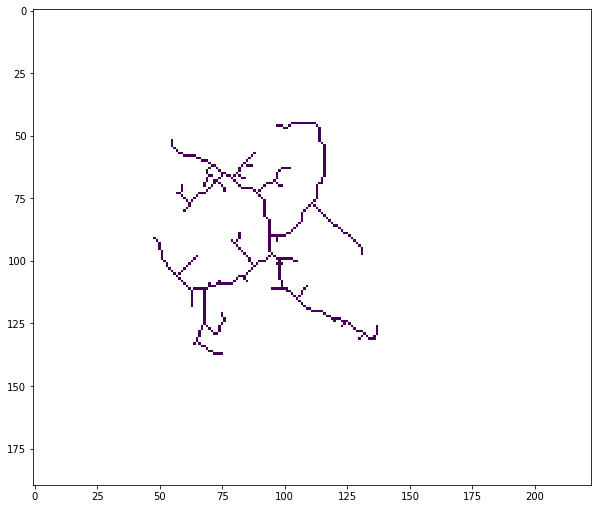

In [21]:
#Plot
arrLCP_ma = np.ma.masked_array(arrLCP,mask=arrLCP==0)
plt.figure(figsize = (10,10))
#plt.imshow(tb_array,cmap=plt.cm.summer)
plt.imshow(arrPipes,cmap=plt.cm.binary)
plt.imshow( arrLCP_ma);